# Analysis of results extracted with Boosting + Complexity Measures

In this notebook we are going to compare the results (error rate and exponential loss) obtained with the three different options we have tested:
* Classic AdaBoost: this implies that weights are initializated with 1/n
* Classic AdaBoost with initial weights modified by means of complexity measures. The idea is that, since boosting iteratively gives more weight to difficult instances, maybe some easy instances are a little bit "forgotten" and by starting by giving more weight to the easiest instances, a good performance is obtained faster. However, I think the correct option is to start by giving more weight to the hardest instances since the easiest ones do not need a lot of effort by the learners, so the learner will easily learn them, but they will have more troubles in correctly predicting the hardest ones, thus, the sooner the learners face the hard instances, the sooner the performence will be acceptable. We will try both options.
* AdaBoost with initial weights modified with complexity measure and weights update modified with complexity measure. We know this option cannot work properly since the weight update in Boosting is performed through theoretical minimization of the exponential loss (in case of AdaBoost). Therefore, any modification regarding these values will be detrimental for the minimization of the objective function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

os.chdir("..")
root_path = os.getcwd()

In [2]:
path_csv = os.chdir(root_path+'/Results_Boosting')
df = pd.read_csv('AggregatedResults_Boosting_parkinsons.csv')

In [3]:
df.head()

,dataset,n_ensemble,method_weights,compl_measure,exp_loss_avg_train_mean,misc_rate_train_mean,misc_rate_test_mean,exp_loss_avg_train_std,misc_rate_train_std,misc_rate_test_std,conf_matrix_test_total
0,parkinsons,1,classic,none,0.677240,0.131620,0.158947,0.023041,0.009803,0.087325,"[[30, 18], [13, 134]]"
1,parkinsons,2,classic,none,0.677240,0.131620,0.158947,0.023041,0.009803,0.087325,"[[30, 18], [13, 134]]"
2,parkinsons,3,classic,none,0.658498,0.123646,0.179474,0.041415,0.017620,0.096314,"[[28, 20], [15, 132]]"
3,parkinsons,4,classic,none,0.670562,0.128779,0.168684,0.029842,0.012697,0.074012,"[[29, 19], [14, 133]]"
4,parkinsons,5,classic,none,0.655743,0.122474,0.163947,0.050545,0.021505,0.101186,"[[31, 17], [15, 132]]"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dataset                  5700 non-null   object 
 1   n_ensemble               5700 non-null   int64  
 2   method_weights           5700 non-null   object 
 3   compl_measure            5700 non-null   object 
 4   exp_loss_avg_train_mean  5700 non-null   float64
 5   misc_rate_train_mean     5700 non-null   float64
 6   misc_rate_test_mean      5700 non-null   float64
 7   exp_loss_avg_train_std   5700 non-null   float64
 8   misc_rate_train_std      5700 non-null   float64
 9   misc_rate_test_std       5700 non-null   float64
 10  conf_matrix_test_total   5700 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 490.0+ KB


In [5]:
stats = df.groupby('method_weights').agg({
    'exp_loss_avg_train_mean': ['mean', 'std'],
    'misc_rate_train_mean': ['mean', 'std'],
    'misc_rate_test_mean': ['mean', 'std']
})

stats


exp_loss_avg_train_mean           misc_rate_train_mean  \
                                       mean       std                 mean   
method_weights                                                               
classic                            0.379289  0.048023             0.004854   
init_easy                          0.388979  0.057097             0.008977   
init_easy_w_complex                0.418746  0.060992             0.021642   

                              misc_rate_test_mean            
                          std                mean       std  
method_weights                                               
classic              0.020432            0.108598  0.012270  
init_easy            0.024293            0.102751  0.020413  
init_easy_w_complex  0.025950            0.139147  0.011768

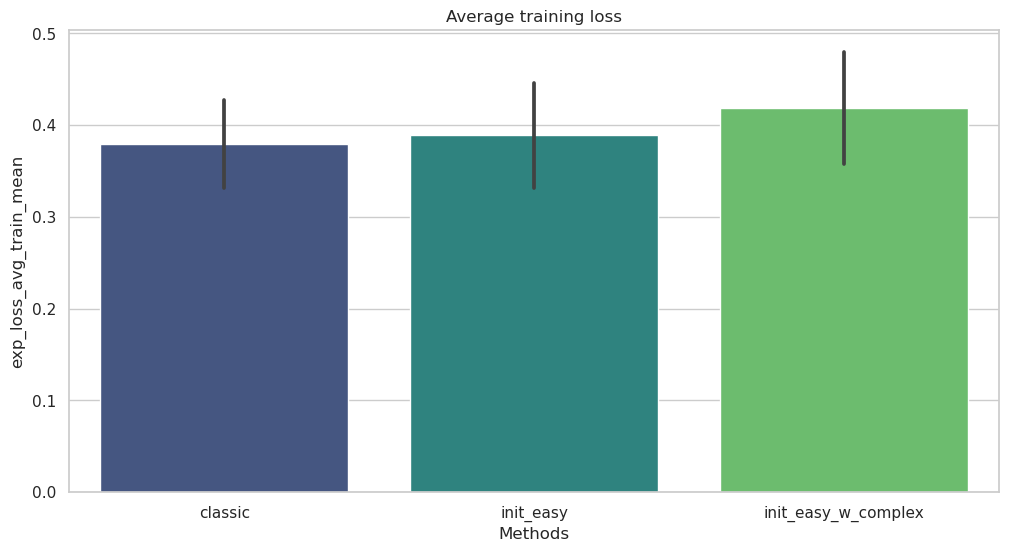

In [6]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Gráfico de barras para exp_loss_avg_train_mean
plt.figure(figsize=(12, 6))
sns.barplot(x='method_weights', y='exp_loss_avg_train_mean', data=df, errorbar="sd", palette="viridis")
plt.title('Average training loss')
plt.ylabel('exp_loss_avg_train_mean')
plt.xlabel('Methods')
plt.show()



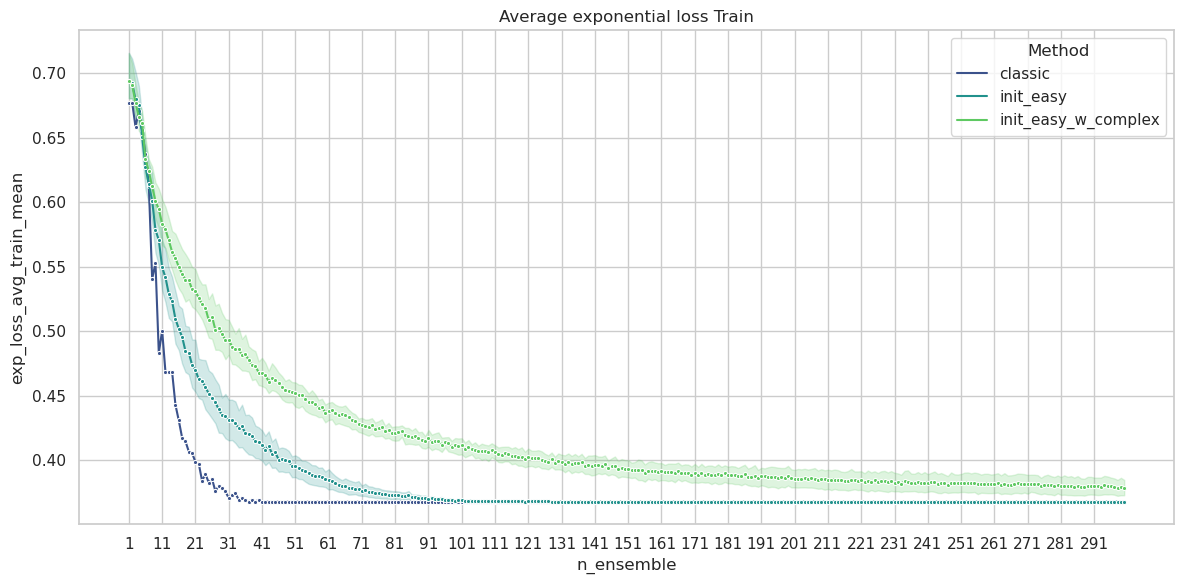

In [8]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df, x='n_ensemble', y='exp_loss_avg_train_mean', hue='method_weights', marker='.', palette='viridis')

plt.title('Average exponential loss Train')
plt.xlabel('n_ensemble')
plt.ylabel('exp_loss_avg_train_mean')
plt.legend(title='Method')
plt.xticks(ticks=range(1, 301, 10)) 
plt.grid(True)
plt.tight_layout()
plt.show()

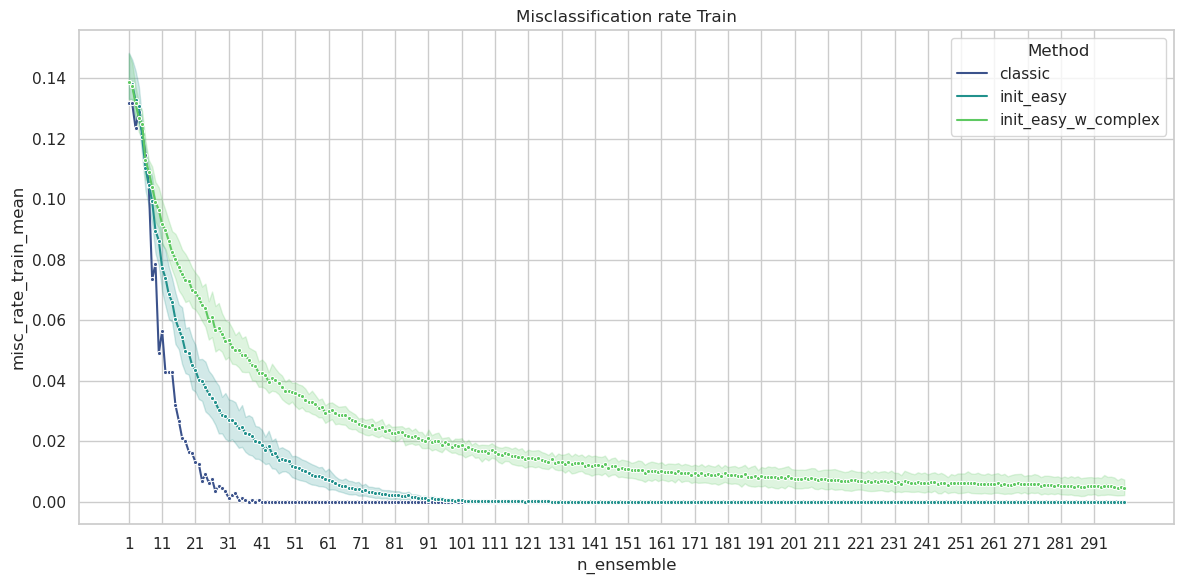

In [9]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df, x='n_ensemble', y='misc_rate_train_mean', hue='method_weights', marker='.', palette='viridis')

plt.title('Misclassification rate Train')
plt.xlabel('n_ensemble')
plt.ylabel('misc_rate_train_mean')
plt.legend(title='Method')
plt.xticks(ticks=range(1, 301, 10)) 
plt.grid(True)
plt.tight_layout()
plt.show()

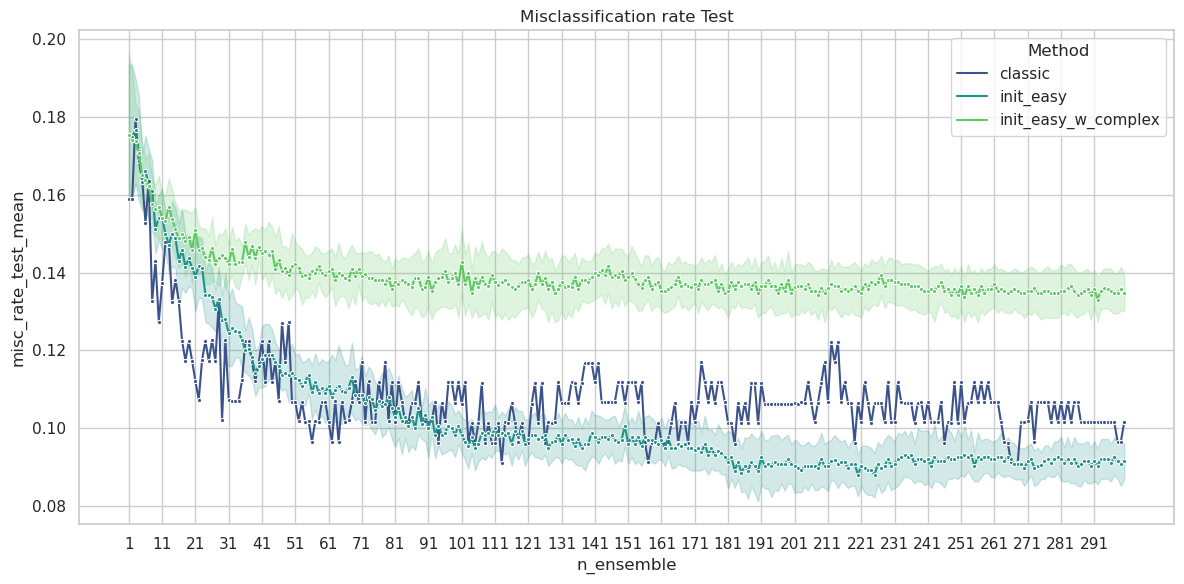

In [20]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df, x='n_ensemble', y='misc_rate_test_mean', hue='method_weights', marker='.', palette='viridis')

plt.title('Misclassification rate Test')
plt.xlabel('n_ensemble')
plt.ylabel('misc_rate_test_mean')
plt.legend(title='Method')
plt.xticks(ticks=range(1, 301, 10)) 
plt.grid(True)
plt.tight_layout()
plt.show()

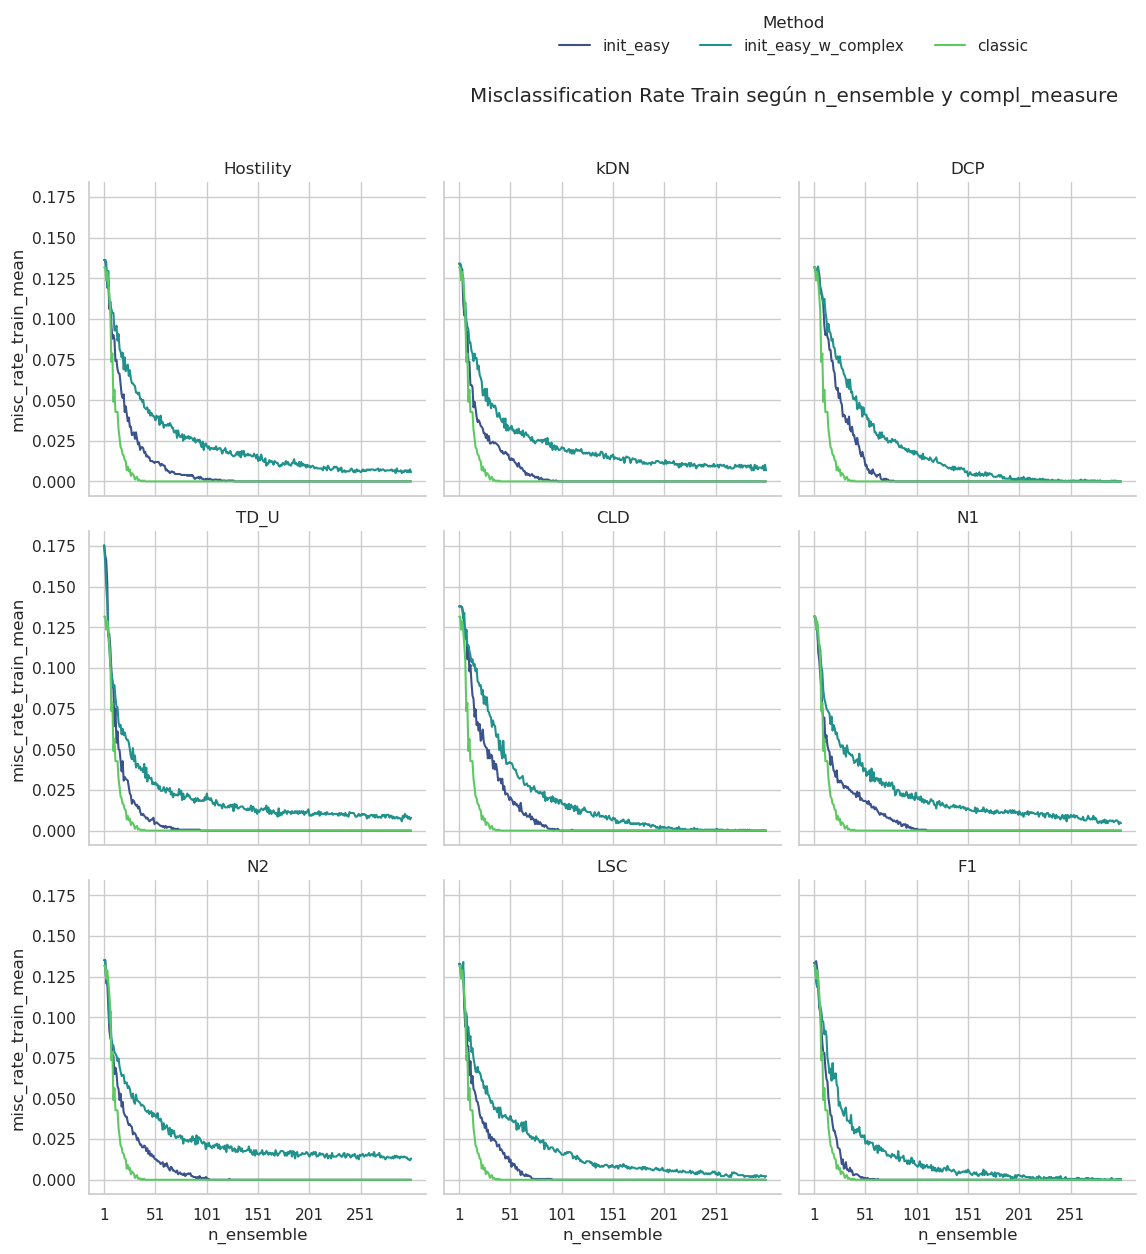

In [23]:
# Crear un nuevo DataFrame que asegure la presencia de 'classic' en cada valor de compl_measure
df_complete = []

for compl in df[df['method_weights'] != "classic"]['compl_measure'].unique():
    # Filtrar los datos para cada compl_measure distinto de "none"
    df_subset = df[df['compl_measure'] == compl]
    
    # Añadir los datos tal cual para los métodos init_easy e init_w
    df_complete.append(df_subset)
    
    # Añadir la línea para 'classic' en el mismo compl_measure
    classic_data = df[(df['method_weights'] == "classic") & (df['compl_measure'] == "none")].copy()
    classic_data['compl_measure'] = compl  # Asignar el compl_measure actual
    df_complete.append(classic_data)

# Concatenar los datos completos en un único DataFrame
df_complete = pd.concat(df_complete)

# Crear la cuadrícula de gráficos con Seaborn
g = sns.FacetGrid(df_complete, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette='viridis')

# Graficar las líneas de tasa de error de clasificación en el conjunto de entrenamiento
g.map(sns.lineplot, 'n_ensemble', 'misc_rate_train_mean')

# Configurar títulos y leyendas
g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "misc_rate_train_mean")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)

# Ajustar etiquetas del eje x para que muestren cada 10 valores
for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

# Ajustar el título general
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Misclassification Rate Train según n_ensemble y compl_measure')  # Título general
plt.show()


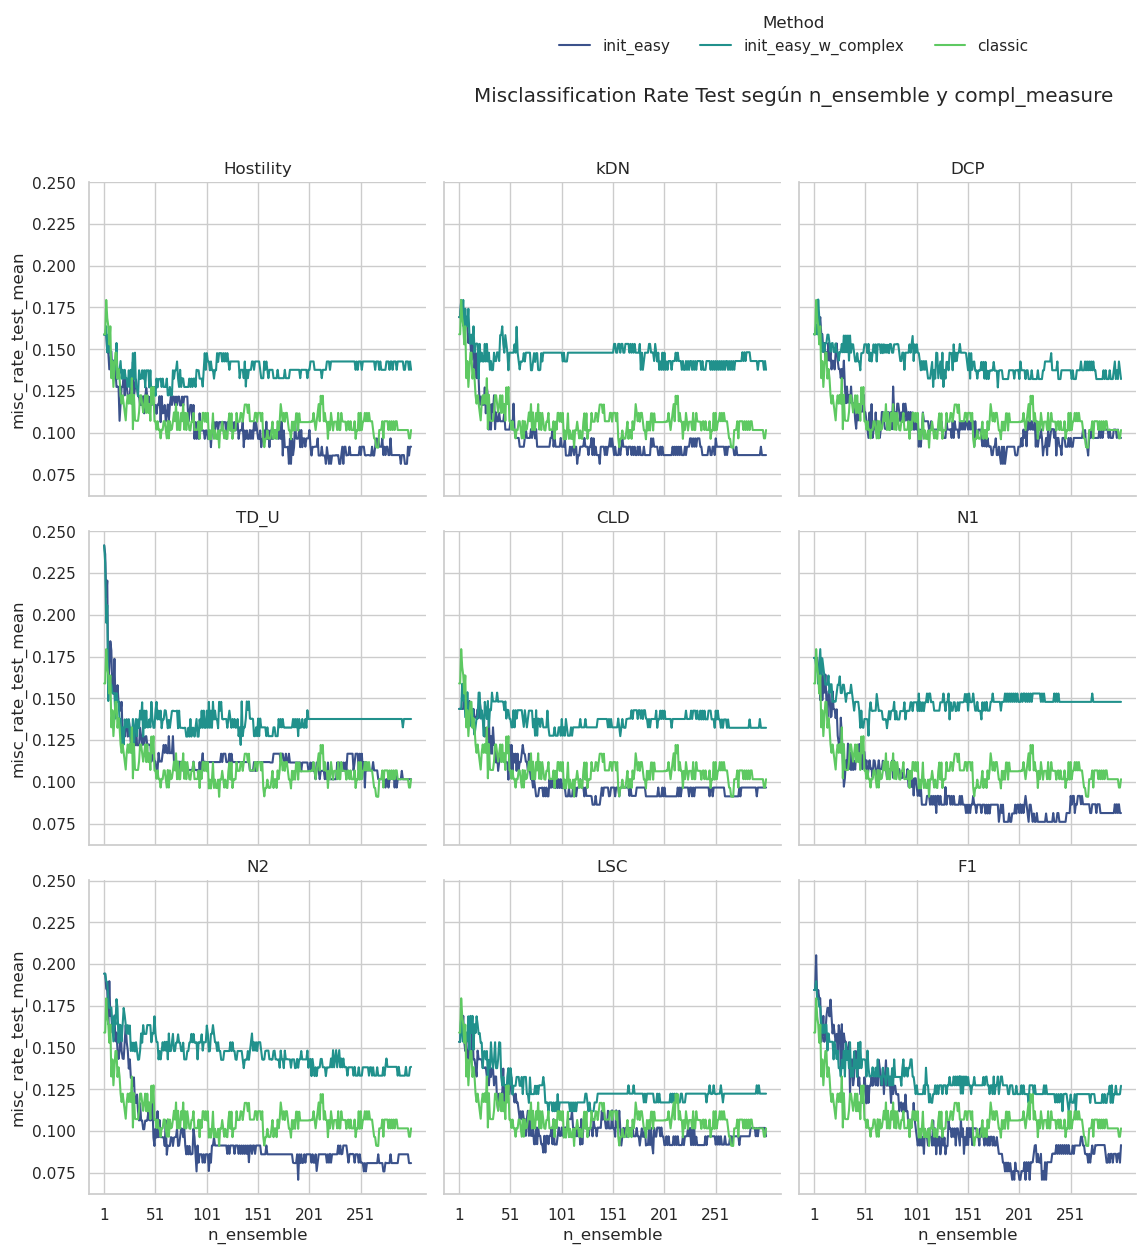

In [24]:
# Crear la cuadrícula de gráficos con Seaborn
g = sns.FacetGrid(df_complete, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette='viridis')

# Graficar las líneas de tasa de error de clasificación en el conjunto de entrenamiento
g.map(sns.lineplot, 'n_ensemble', 'misc_rate_test_mean')

# Configurar títulos y leyendas
g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "misc_rate_test_mean")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)

# Ajustar etiquetas del eje x para que muestren cada 10 valores
for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

# Ajustar el título general
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Misclassification Rate Test según n_ensemble y compl_measure')  # Título general
plt.show()


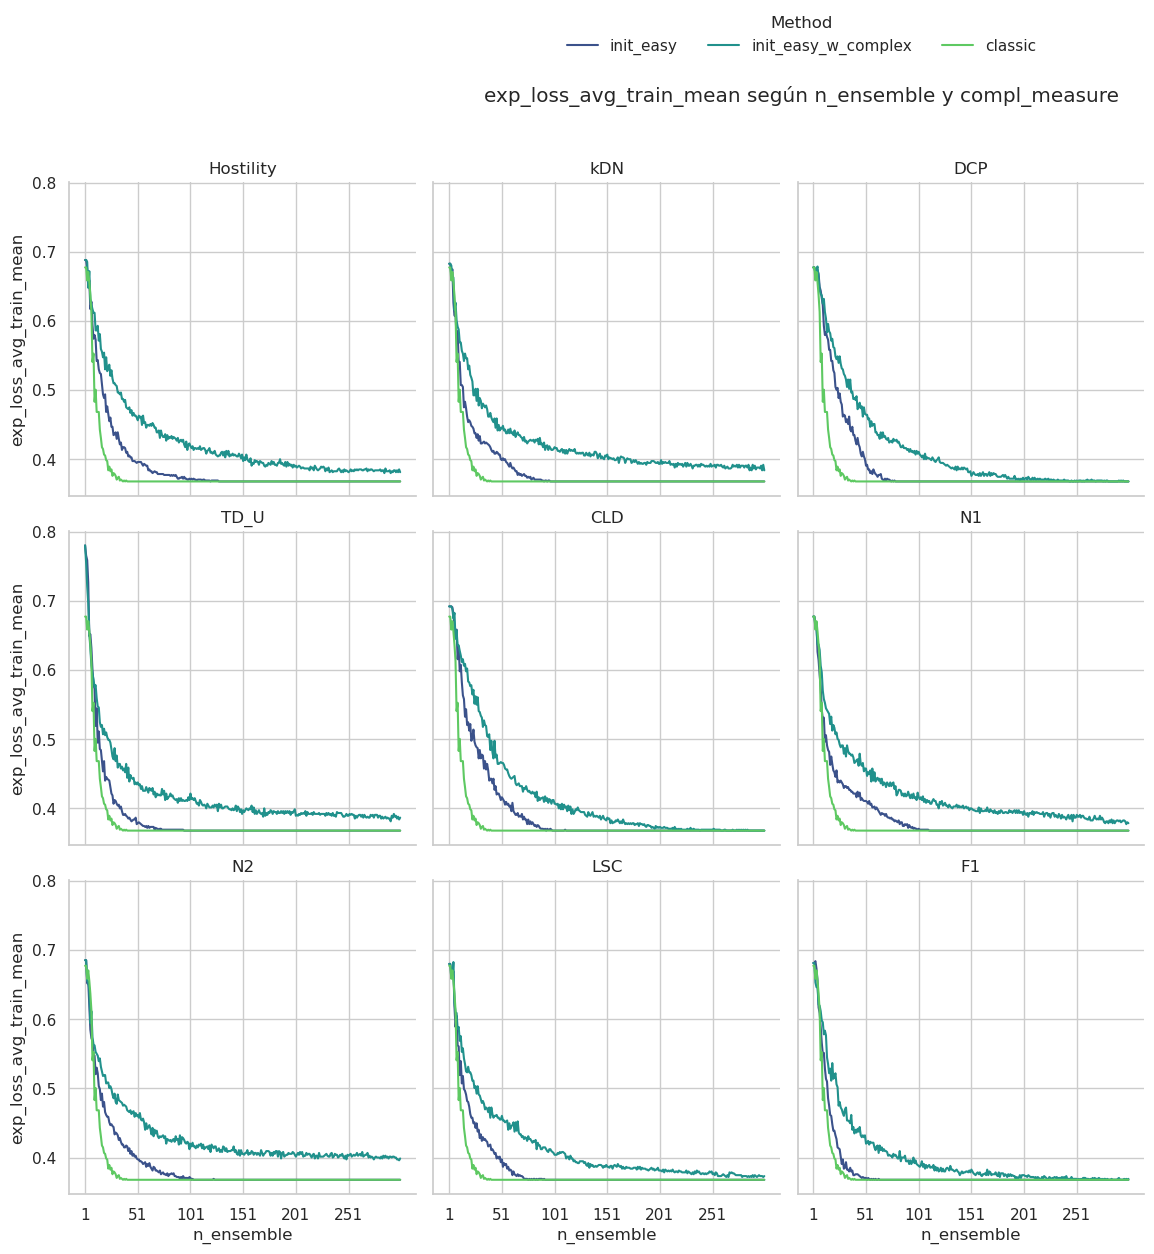

In [25]:
# Crear la cuadrícula de gráficos con Seaborn
g = sns.FacetGrid(df_complete, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette='viridis')

# Graficar las líneas de tasa de error de clasificación en el conjunto de entrenamiento
g.map(sns.lineplot, 'n_ensemble', 'exp_loss_avg_train_mean')

# Configurar títulos y leyendas
g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "exp_loss_avg_train_mean")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)

# Ajustar etiquetas del eje x para que muestren cada 10 valores
for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

# Ajustar el título general
plt.subplots_adjust(top=0.9)
g.fig.suptitle('exp_loss_avg_train_mean según n_ensemble y compl_measure')  # Título general
plt.show()